In [13]:
import pandas as pd
from sqlalchemy import create_engine
from itertools import combinations
import numpy as np
from sklearn.linear_model import LinearRegression

%matplotlib inline

<h3><center>Modeling</center><h3>

In this step we will build a model that will forecast the closing price.

For this, we will build some modeling pipelines, which will test different pre-processing, as well as models as well.

The intention is that our model will be able to perform with the chosen metrics and provide us with a forecast with the minimum acceptable error, which we already decided at the beginning of the study (< 5%).

<h4>Load Data from Database</h4>

In order for us to begin the data exploration and understanding step, we need to collect the data that has already been treated and that were entered into our database, in the previous step.

For this, let's run the step below, creating a Pandas Dataframe, which will contain all the Bitcoin history we want.

Let's remove the last day as there is no next day field for it.

In [2]:
# create database file and engine
engine = create_engine('sqlite:///database/database.db', echo=False)

# define query to run
query = """select
                  date
                , open
                , high
                , low
                , close
                , volume
           from historical"""

# read sql from database using query
frame = pd.read_sql(
    query, 
    con=engine,
    parse_dates=['date']
)


# create column with next day close price
frame['closing_next'] = frame['close'].shift(-1)
frame.head()

# delete last day
frame.dropna(inplace=True)

<h4>Training<h4>
    
Model operation:

The model performs a new training of a linear regression for each chunck from previous periods, and is used to perform, based on the D-day data, the next day's closing forecast. D-day data is not used in training. For example: let's use the D-6 to D-1 range for training. We apply the D-trained model to predict the closure of D+1.

To predict the next day, the date chunk is modified so that it continues to fetch only the last N periods.

<img src='model_explain.jpeg'/>

In [3]:
def columns_possible_generator(columns):
    """
    generate list with all possible combinations of columns
    
    Input:
        columns: list with all columns
    Output:
        columns_possible: list of all combinations
    """
    columns_possible = list()
    for i in range(1,len(columns)+1):
        columns_possible.extend(list(item for item in combinations(columns, i)))
    return columns_possible

def get_metrics(true, predict):
    """
    generates a list with the defined evaluation metrics: 
    root mean square error, percentage mean error, 
    percentage median error, quantile 95th percentage error
    
    Input:
        true: array with real values
        predict: array with predict values
    Output:
        list with all metrics values
    """
    true = np.array(true)
    predict = np.array(predict)
    #root mean square error
    rmse = np.sqrt(np.sum(np.power(true - predict, 2))/len(true))
    # percentage mean diff
    pmd = np.mean(np.abs((predict/true) - 1))
    # percentage median diff
    pmed = np.median(np.abs((predict/true)-1))
    # quantile 95th abs percentual error
    qape = np.quantile(np.abs(true/predict-1), .90)
    
    return [rmse, pmd, pmed, qape]
    


def test_model(frame, columns, range_periods):
    """
    trains a model for each possible combination of the passed parameters, 
    and returns the metrics for each of them.
    The model is trained using the N previous periods, and the intention is 
    to predict the next period, based on current data. 
    Example: Use the closing data for the last 5 days to train a model 
    and forecast the next day.
    
    Input:
        frame: dataframe
        columns: possible columns to test the model
        range_periods: tuple with a range of periods that will be 
            used to search how many previous days will be used 
            to train the model
    Output:
        db: list with all possibles parameters combined and the result of with one
    """
    db = list()
    for var_columns in columns_possible_generator(columns):
        if len(var_columns) == 1:
            for period in range(range_periods[0], range_periods[1]+1):
                predict = list()
                true = list()
                for ix in frame.index:
                    if (ix-period >= period):
                        x_train = frame.loc[ix-period : ix-1, var_columns].values
                        y_train = frame.loc[ix-period : ix-1, 'closing_next'].values
                        x_test = frame.loc[ix, var_columns]
                        y_test = frame.loc[ix, 'closing_next']
                        lr = LinearRegression()
                        lr.fit(x_train, y_train)
                        predict.append(lr.predict(x_test.reshape(1,-1))[0])
                        true.append(y_test)
                metrics = get_metrics(true, predict)
                to_insert = [var_columns, period]
                to_insert.extend(metrics)
                db.append(to_insert)
        else: 
            for period in range(range_periods[0], range_periods[1]+1):
                predict = list()
                true = list()
                for ix in frame.index:
                    if (ix-period >= period):
                        x_train = frame.loc[ix-period : ix-1, list(var_columns)].values
                        y_train = frame.loc[ix-period : ix-1, 'closing_next'].values
                        x_test = frame.loc[ix, list(var_columns)].values
                        y_test = frame.loc[ix, 'closing_next']
                        lr = LinearRegression()
                        lr.fit(x_train, y_train)
                        predict.append(lr.predict(x_test.reshape(1,-1))[0])
                        true.append(y_test)
                metrics = get_metrics(true, predict)
                to_insert = [var_columns, period]
                to_insert.extend(metrics)
                db.append(to_insert)
    return db


Using the test_model function, a model will be trained for each possible combination of predictor variables, and periods used for training. The result of each training will be stored in a list, which will contain the parameters, which can be evaluated.

In [4]:
evaluated_models = test_model(frame, ['open', 'close', 'low', 'high', 'volume'], (7,30))

<h4>Parameters search result</h4>

With the training result stored in a list, we will transform it into a Pandas dataframe, so that we can view the results and sort according to the desired metric, which is the median of the percentage of error (pmed).

The combination of parameters that brought the best result was:

Columns: [close]

Periods: 29

In [5]:
frame_result = pd.DataFrame(evaluated_models, columns=['columns', 'period', 'rmse', 'pmd', 'pmed', 'qape'])
frame_result.sort_values(by='pmed', inplace=True)
frame_result

,columns,period,rmse,pmd,pmed,qape
46,"(close,)",29,689.729252,0.027752,0.017066,0.065023
43,"(close,)",26,689.138380,0.027982,0.017086,0.066203
45,"(close,)",28,688.172209,0.027867,0.017109,0.066221
42,"(close,)",25,687.929338,0.028008,0.017127,0.066021
283,"(close, volume)",26,715.144730,0.029175,0.017141,0.067764
...,...,...,...,...,...,...
115,"(volume,)",26,1913.825044,0.078107,0.056844,0.178564
116,"(volume,)",27,1960.091854,0.079358,0.058038,0.180877
117,"(volume,)",28,1913.633643,0.080440,0.058989,0.184435
118,"(volume,)",29,1948.808691,0.081786,0.059824,0.186695


<h4>Model Refit</h4>
Based on the parameter search we performed, we will retrain the model using the parameters that returned with the smallest median percentage error.

When retraining the model, we will include in a copy of the original dataframe, a new column, which will be the model forecast, so that we can better understand the performance and data quality of the forecasts obtained.

The days in which our model did not perform the forecast will also be removed, as it did not reach the minimum number of days before the model was capable of training.

In [7]:
def train_model(frame, columns, period):
    """
    train model using parameters and add forecast column to dataframe
    
    Input:
        frame: dataframe
        columns: columns used on regression
        period: number of days used to train regression
    Output:
        frame: dataframe with column of forecast value
    """
    df = frame.copy(deep=True)
    if len(columns) == 1:
        for ix in df.index:
            if (ix-period >= period):
                x_train = df.loc[ix-period : ix-1, columns].values
                y_train = df.loc[ix-period : ix-1, 'closing_next'].values
                x_test = df.loc[ix, columns].values
                lr = LinearRegression()
                lr.fit(x_train, y_train)
                df.loc[ix, 'predict_value'] = lr.predict(x_test.reshape(1,-1))
    else:
        for ix in df.index:
            if (ix-period >= period):
                x_train = df.loc[ix-period : ix-1, list(columns)].values
                y_train = df.loc[ix-period : ix-1, 'closing_next'].values
                x_test = df.loc[ix, list(columns)].values
                lr = LinearRegression()
                lr.fit(x_train, y_train)
                df.loc[ix, 'predict_value'] = lr.predict(x_test.reshape(1,-1))
    df.dropna(inplace=True)
    return df

In [8]:
df = train_model(frame, ['close'], 29)
df['error'] = abs(df['closing_next'] - df['predict_value'])
df['percentual_error'] = (abs(df['closing_next'] - df['predict_value']))/df['closing_next']
df

,date,open,high,low,close,volume,closing_next,predict_value,error,percentual_error
58,2014-11-14,418.416992,419.252014,384.789001,397.817993,2.958920e+07,376.132996,393.544121,17.411125,0.046290
59,2014-11-15,399.649994,405.528015,371.007996,376.132996,1.572750e+07,387.881989,373.491452,14.390537,0.037100
60,2014-11-16,374.730011,390.799011,374.601990,387.881989,1.190560e+07,387.407990,383.324659,4.083331,0.010540
61,2014-11-17,388.348999,410.199005,377.502014,387.407990,4.151880e+07,375.197998,382.972211,7.774213,0.020720
62,2014-11-18,387.785004,392.402008,371.117004,375.197998,3.222250e+07,380.554993,372.503551,8.051442,0.021157
...,...,...,...,...,...,...,...,...,...,...
2482,2021-07-04,34665.566406,35937.566406,34396.476563,35287.781250,2.492431e+10,33746.003906,35316.509945,1570.506039,0.046539
2483,2021-07-05,35284.343750,35284.343750,33213.660156,33746.003906,2.672155e+10,34235.195313,34153.865140,81.330173,0.002376
2484,2021-07-06,33723.507813,35038.535156,33599.917969,34235.195313,2.650126e+10,33855.328125,34569.838196,714.510071,0.021105
2485,2021-07-07,34225.679688,34997.664063,33839.289063,33855.328125,2.479603e+10,32877.371094,34296.875585,1419.504491,0.043176


With the model trained again, and using the parameter that gave us the best error rates, we created a new dataframe, with the forecast, absolute error and percentage error columns. The latter is our main model measurement error, as we want our average error not to exceed 5%.

If we look at this new column with the mean error, we can see that the mean was 2.77%, the median 1.7%, and 75% of the predicted data had a maximum error of 3.7%. Based on this, we consider that the model has achieved our main objective.

In [11]:
#median, mean and 75th percentil
df.percentual_error.describe()

count    2429.000000
mean        0.027752
std         0.033820
min         0.000046
25%         0.006851
50%         0.017066
75%         0.037180
max         0.587013
Name: percentual_error, dtype: float64

<h4>Histogram of percentage error</h4>

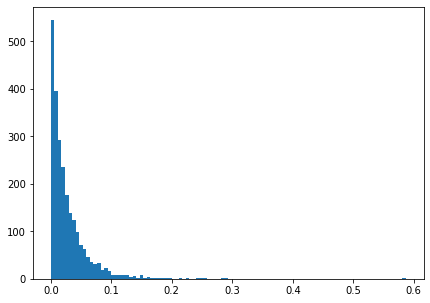

In [17]:
df.percentual_error.hist(grid=False, figsize=(7,5), bins=100)

<h4>Comparison between predicted and actual</h4>

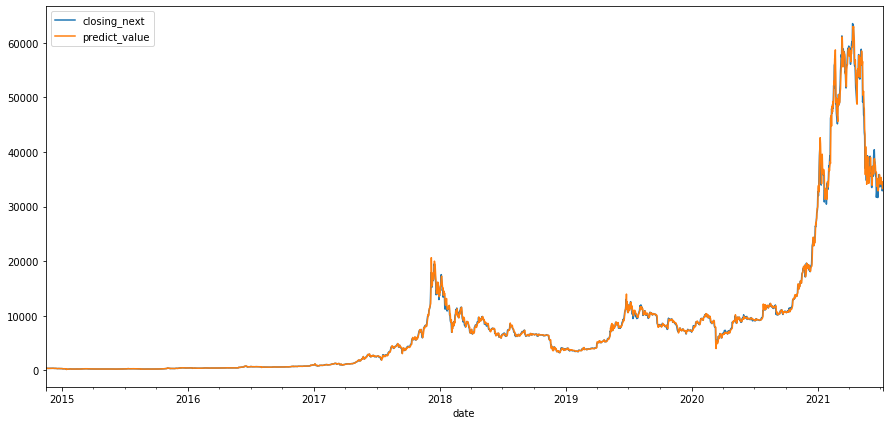

In [24]:
df[[
    'closing_next', 'predict_value','date'
   ]].plot(
    kind='line',
    figsize=(15,7),
    x='date'
)

The biggest errors in the model were on dates when Bitcoin suffered big drops, or big advances in its price, due to market factors that there is no way to predict, facts that also happen on stock exchanges around the world.

In [23]:
df.sort_values(by='percentual_error', ascending=False).head(10)

,date,open,high,low,close,volume,closing_next,predict_value,error,percentual_error
2002,2020-03-11,7910.089844,7950.814453,7642.812500,7911.430176,3.868276e+10,4970.788086,7888.704438,2917.916352,0.587013
119,2015-01-14,223.893997,223.893997,171.509995,178.102997,9.763870e+07,209.843994,148.732696,61.111298,0.291223
2003,2020-03-12,7913.616211,7929.116211,4860.354004,4970.788086,5.398036e+10,5563.707031,3986.915796,1576.791235,0.283407
1092,2017-09-13,4131.979980,4131.979980,3789.919922,3882.590088,2.219410e+09,3154.949951,3968.010156,813.060205,0.257709
118,2015-01-13,267.394012,268.277008,219.906006,225.860992,7.284390e+07,178.102997,222.668257,44.565260,0.250222
1743,2019-06-26,11778.581055,13796.489258,11755.597656,13016.231445,4.510573e+10,11182.806641,13962.268679,2779.462038,0.248548
1177,2017-12-07,14266.099609,17899.699219,14057.299805,17899.699219,1.795070e+10,16569.400391,20631.475201,4062.074810,0.245155
334,2015-08-17,258.489990,260.505005,257.117004,257.976013,2.161790e+07,211.078995,258.593917,47.514922,0.225105
1216,2018-01-15,13767.299805,14445.500000,13641.700195,13819.799805,1.275080e+10,11490.500000,14074.383647,2583.883647,0.224871
1236,2018-02-04,9175.700195,9334.870117,8031.220215,8277.009766,7.073550e+09,6955.270020,8440.559118,1485.289098,0.213549


<center><h3>Conclusions</h3></center>

In the present work, the construction of a model that aimed to predict the next day's closing price, using data from the day or previous days, was conceived. The model error, and evaluation metric, is the percentage error between the actual value and the predicted value. We idealized that the error should be below 5% when we look at the average of the entire historical period.

The model is based on linear regression, and uses data from X previous periods (days) for training, using only the last day to forecast the next day's closing. In this way, we will always have a training and test set.

A function was built so that the best model could be found, testing a variation between periods and between columns that could be used as predictor variables. Based on these tests, we found the best model, which was using 29 periods and only the "close" column.

The model was then retrained, and a new dataframe was built with forecast, absolute error and percentage error columns.

Based on this new dataframe, and error measures, we verified that the average error obtained was below our target, which was 5%, as well as the median.

The error measures found were:

- Average of errors: 2.77%


- Median of errors: 1.7%

The biggest deviations between the model's prediction and reality occurred on days when the market suffered some distortions, caused mainly by what in the world of trades are called "whale movements", and the price came to vary by more than 30% of overnight.

We concluded that the performance of the model was satisfactory, and we considered our study to be valid, since we stayed within the desired error metric.